In [4]:
from fedcore.architecture.dataset.object_detection_datasets import YOLODataset, COCODataset
from torchvision.transforms import v2

import numpy as np
import torch
import torch.nn
import torchvision.datasets
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from torch import nn, optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from PIL import ImageDraw

from fedcore.architecture.comptutaional.devices import default_device
from fedcore.architecture.utils.loader import collate
from fedcore.data.data import CompressionInputData
from fedcore.inference.onnx import ONNXInferenceModel
from fedcore.neural_compressor.config import Torch2ONNXConfig
from fedcore.repository.constanst_repository import FEDOT_TASK
from fedcore.repository.initializer_industrial_models import FedcoreModels
from fedcore.repository.constanst_repository import CROSS_ENTROPY, MSE
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights,\
    fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from fedcore.tools.ruler import PerformanceEvaluatorOD
from torchmetrics.detection import MeanAveragePrecision as MAP
from torchvision.ops import nms

In [5]:
device = default_device()
IMG_SIZE = 512
NMS_THRESH = 0.6

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

INIT_LR = 4e-5

NUM_EPOCHS = 1
BATCH_SIZE = 4

DATASET_NAME = 'african-wildlife'

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=MEAN, std=STD),
    # v2.Resize((IMG_SIZE, IMG_SIZE))
])

train_dataset = YOLODataset(dataset_name='african-wildlife', transform=transform, train=True)
# train_dataset = COCODataset(images_path=COCO_PATH + "train2017/",
#                             json_path=COCO_PATH + "annotations/instances_train2017.json",
#                             transform=transform)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

val_dataset = YOLODataset(dataset_name='african-wildlife', transform=transform, train=False)
# val_dataset = COCODataset(images_path=COCO_PATH + "val2017/",
#                             json_path=COCO_PATH + "annotations/instances_val2017.json",
#                             transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.1, 0.9])
val_loader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False,
    collate_fn=collate
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False,
    collate_fn=collate
)

# More accurate, very slow to train
# model = fasterrcnn_resnet50_fpn_v2()

# Less accurate, but faster to train
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# test
# model = ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
# model = retinanet_resnet50_fpn_v2()

num_classes = len(train_dataset.classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)
model.to(device)

opt = optim.SGD(model.parameters(), lr=INIT_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, verbose=True)
evaluator = PerformanceEvaluatorOD(model, test_loader, batch_size=BATCH_SIZE)

c:\Users\Kaefsky\test\FedCore\datasets\african-wildlife
c:\Users\Kaefsky\test\FedCore\datasets\african-wildlife


In [7]:
train_loss = list()
val_loss = list()
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_loss = np.zeros(len(train_loader))
    for i, (images, targets) in enumerate(train_loader):
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        opt.zero_grad()
        loss.backward()
        opt.step() 
        running_loss += loss.item()
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
        epoch_loss[i] = loss
    if device == 'cuda':
        torch.cuda.empty_cache()   
    model.eval()
    target_metric = evaluator.measure_target_metric()
    print('[%d] MAP: %.3f' %
                     (epoch + 1, target_metric["map"]))
    scheduler.step(float(target_metric["map"]))
    train_loss.append(epoch_loss.mean())
    val_loss.append(float(target_metric["map"]))
    if len(val_loss) > 4 and val_loss[-1] == val_loss[-6]:
            print("Early stopping")
            break
performance = evaluator.eval()
print('Before quantization')
print(performance)

[1,     1] loss: 0.057
[1,    51] loss: 2.538
[1,   101] loss: 2.383
[1,   151] loss: 2.374
[1,   201] loss: 2.238
[1,   251] loss: 2.290


Measuring target metric: 202batch [00:08, 24.25batch/s]


[1] MAP: 0.014


Measuring throughput: 100%|██████████| 5/5 [00:00<00:00, 32.15batch/s]
Measuring target metric: 202batch [00:06, 31.50batch/s]


Latency: 0.14719 ms/sample with batch_size 4
Throughput: 95822.0 samples/s with batch_size 4
Model size: 72.458 MB
Before quantization
{'latency': 0.14719, 'throughput': 95822.0, 'model_size': 72.458, 'target_metrics': {'map': tensor(0.0137), 'map_50': tensor(0.0543), 'map_75': tensor(0.0005), 'map_small': tensor(0.), 'map_medium': tensor(0.0038), 'map_large': tensor(0.0228), 'mar_1': tensor(0.0663), 'mar_10': tensor(0.2458), 'mar_100': tensor(0.3091), 'mar_small': tensor(0.), 'mar_medium': tensor(0.2244), 'mar_large': tensor(0.3209), 'classes': tensor([1, 2, 3, 4], dtype=torch.int32)}}


In [ ]:
torch.save(model, f'{model._get_name()}_' + DATASET_NAME)

In [ ]:
model = model.cpu()
repo = FedcoreModels().setup_repository()
compression_pipeline = PipelineBuilder().add_node('post_training_quant').build()

input_data = CompressionInputData(features=np.zeros((2, 2)),
                                    idx=None,
                                    calib_dataloader=val_loader,
                                    task=FEDOT_TASK['regression'],
                                    data_type=None,
                                    target=model
)

input_data.supplementary_data.is_auto_preprocessed = True
compression_pipeline.fit(input_data)
quant_model = compression_pipeline.predict(input_data).predict

2024-07-06 17:13:02 [INFO] Start auto tuning.
2024-07-06 17:13:02 [INFO] Quantize model without tuning!
2024-07-06 17:13:02 [INFO] Quantize the model with default configuration without evaluating the model.                To perform the tuning process, please either provide an eval_func or provide an                    eval_dataloader an eval_metric.
2024-07-06 17:13:02 [INFO] Adaptor has 5 recipes.
2024-07-06 17:13:02 [INFO] 0 recipes specified by user.
2024-07-06 17:13:02 [INFO] 3 recipes require future tuning.
2024-07-06 17:13:02 [INFO] *** Initialize auto tuning
Exception in thread 2024-07-06 17:13:02 [INFO] {
Thread-8:
Traceback (most recent call last):
  File "C:\Users\Kaefsky\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
2024-07-06 17:13:02 [INFO]     'PostTrainingQuantConfig': {
2024-07-06 17:13:02 [INFO]         'AccuracyCriterion': {
2024-07-06 17:13:02 [INFO]             'criterion': 'relative',
2024-07-06 17:13:02 [INFO]          

In [ ]:
torch.save(model, 'fasterrcnn_mobilenet_v3_large_fpn.pt')

In [ ]:
int8_onnx_config = Torch2ONNXConfig(
    dtype="int8",
    opset_version=18,
    quant_format="QDQ",  # or "QLinear"
    example_inputs=torch.unsqueeze(train_dataset[0][0], dim=0),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
            'input' : {0 : 'batch_size'},
            'output' : {0 : 'batch_size'}
        }
)

quant_model.export("int8-model.onnx", int8_onnx_config)
onnx_model = ONNXInferenceModel("int8-model.onnx")

RuntimeError: Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions

In [ ]:
evaluator = PerformanceEvaluatorOD(model, test_loader, batch_size=1)
performance = evaluator.eval()
print('after quantization')
print(performance)

: 

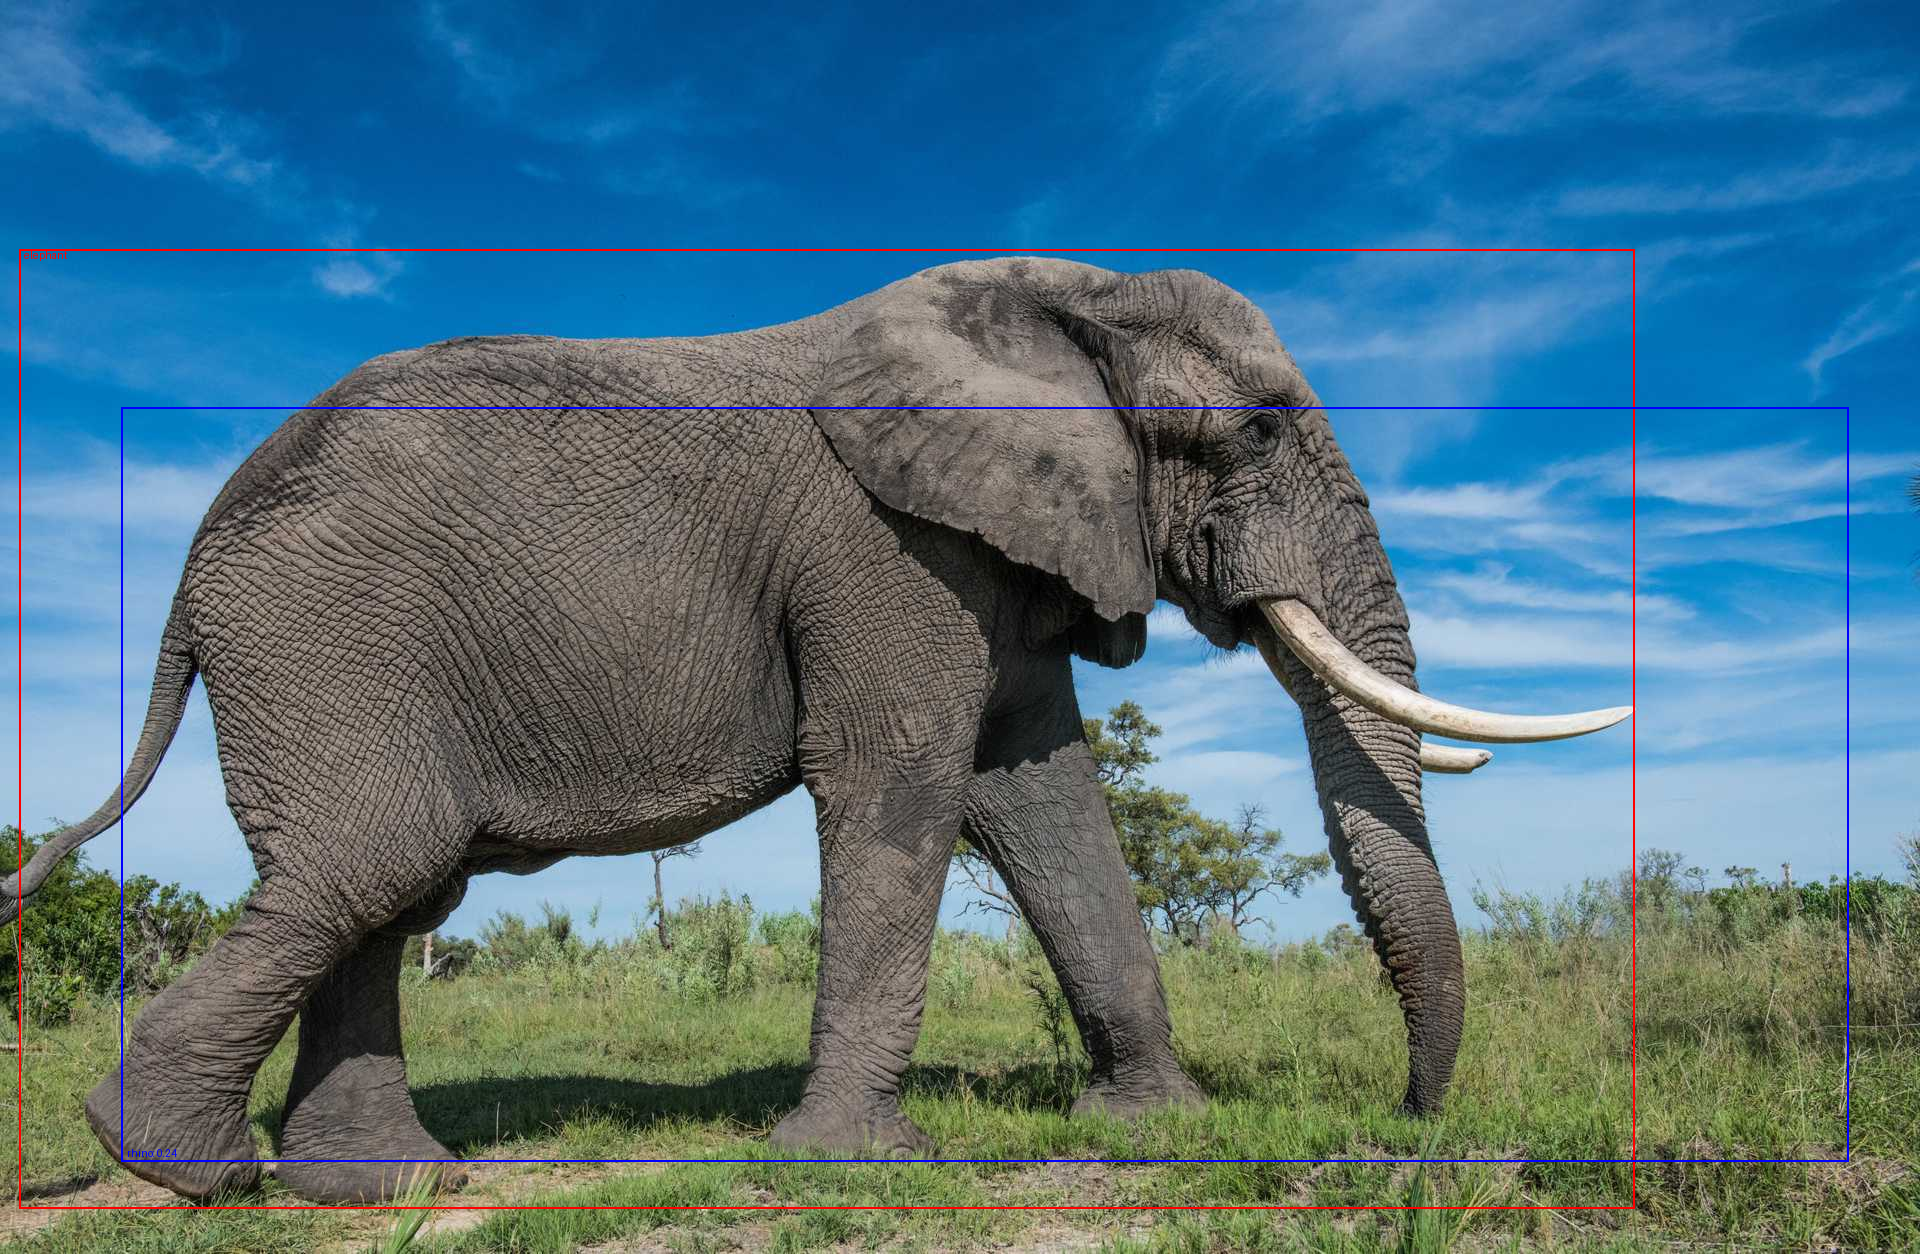

In [21]:
import random
model = torch.load('FasterRCNN_african-wildlife.pt')
model.eval()
model.cpu()
val_data = val_dataset[random.randint(0, len(val_dataset) - 1)]
img = val_data[0]
targets = val_data[1]
input = torch.unsqueeze(img, dim=0)
preds = model(input)
b_count = val_data[1]['boxes'].size(0)

transform = v2.ToPILImage()
img = transform(img)
draw = ImageDraw.Draw(img)

for i in range(b_count):
    x1, y1, x2, y2 = targets["boxes"].detach().numpy()[i]
    draw.rectangle([x1, y1, x2, y2], fill=None, outline="red", width=2)
    label = str(train_dataset.classes[targets["labels"].numpy()[i]])
    draw.text([x1+5, y1], text=label, fill="red")
    
    x1, y1, x2, y2 = preds[0]["boxes"].detach().numpy()[i]
    draw.rectangle([x1, y1, x2, y2], fill=None, outline="blue", width=2)
    label = train_dataset.classes[preds[0]["labels"].numpy()[i]]
    score = preds[0]["scores"].detach().numpy()[i]
    text = f'{label}: {score:.2f}'
    draw.text([x1+5, y2-15], text=text, fill="blue")
    
display(img)

In [14]:
import random
from fedcore.architecture.visualisation.visualization import show_image

model.eval()
model.cpu()
val_data = val_dataset[random.randint(0, len(val_dataset) - 1)]
img = val_data[0]
targets = val_data[1]
input = torch.unsqueeze(img, dim=0)
preds = model(input)
b_count = val_data[1]['boxes'].size(0)

transform = v2.ToPILImage()
img = transform(img)

    
show_image(img, targets, preds, train_dataset.classes)